# Chapter 12: Information Analysis

## Summary
- Information analysis is a two-step process
- Step 1 is to turn information into portfolios
- Step 2 is to analyse the performance of those portfolios
- Event studies provide analysis when information arrives episodically

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
%matplotlib inline

## Information & Active Management

- Active Managers use information to predict the future exceptional return on a group of stock
- The emphasis is on predicting _alpha_ or residual return, beta-adjusted return relative to a benchmark
- We call a set of data a _predictor_
- Any predictor is made up of signal plus noise
- Information analysis is an effort to find the signal-to-noise ratio
- Predictors are limited only by availability and imagination

**Information Classification Dimensions**
- Primary or processed
- Judgemental or impartial
- Ordinal or cardinal
- Historical, contemporary, or forecast


## Step 1: Information into Portfolios ##

**Some possible approaches**
- _Procedure 1_ &emsp; With buy/sell recommendations we could equal- (or value-) weight the buy group and the sell group
- _Procedure 2_ &emsp; With scores, we can build a portfolio for each score by equal- (or value-) weighting within each score category
- _Procedure 3_ &emsp; With straight alphas we can split the stocks into tw groups (higher than average, lower than average alphas)  We can then weight the stocks by how far their alpha is from the average
- _Procedure 4_ &emsp; With straight alphas we can rank the assets according to alpha and then group into e.g. quintiles
- _Procedure 5_ &emsp; With any numerical score we can build a factor portfolio that bets on the prediction and does not make a market bet.  Factor portfolio consists of a long portfolio and a short portfolio (of equal value and beta but the long portfolio will have a unit bet on the prediction relative to the short portfolio)
- _Procedure 6_ &emsp; With any numerical score we can build a factor portfolio (as above) designed so that the long and short portfolios are matched on a set of pre-specified control variables.  e.g. we could ensure the long and short portfolios match on industry, sector etc

## Step 2: Performance Evaluation

**Example A**
- build a portfolio using Procedure 2 (rank S&P assets by book to price ratio and divide them into quintiles such that each quintile has equal capitalisation.

**Example B**
- build a portfolio using Procedure 5 (Build a long and short portfolio) - each will have equal value and beta.  The long portfolio will exhibit a book to price ratio one standard deviation above that of the short portfolio.

What can these example tell us about information contained in book-to-price ratios ?



In [2]:
# S&P 100 reference data
ticker_symbol = "^OEX"
oex_df = yf.download(ticker_symbol, start="2015-12-01", end="2023-12-31", interval='1mo', progress=False)
oex_df = oex_df.resample('QE').last()
oex_df['OEX_pct_change'] = oex_df['Close'].pct_change() * 100
oex_df['Cumulative_pct_change'] = oex_df['OEX_pct_change'].cumsum()
oex_df.head()

Price,Close,High,Low,Open,Volume,OEX_pct_change,Cumulative_pct_change
Ticker,^OEX,^OEX,^OEX,^OEX,^OEX,,
Date,,,,,,,
2015-12-31,911.429993,937.900024,890.200012,927.080017,83649260000,NaN,NaN
2016-03-31,912.929993,919.669983,861.210022,861.210022,92639420000,0.164577,0.164577
2016-06-30,928.130005,935.890015,883.200012,926.760010,86852700000,1.664970,1.829547
2016-09-30,958.679993,967.270020,939.280029,959.950012,77023620000,3.291563,5.121110
2016-12-31,991.429993,1007.010010,964.700012,969.260010,75344550000,3.416156,8.537266


In [3]:
# price/book - get the P/B ratio at the start of series and divide into quintiles
pb = pd.read_csv('data/sp100_price_to_book.csv')
pbT = pb.copy()
pbT = pbT.T
pbT = pbT[[0]].iloc[1:]
pbT.rename(columns={0:'price/book'}, inplace=True)

# market/cap
mc = pd.read_csv('data/sp100_market_cap.csv')
mcT = mc.copy()
mcT = mcT.T
mcT = mcT[[0]].iloc[1:]
mcT.rename(columns={0:'market_cap'}, inplace=True)

mcT = pd.merge(mcT, pbT, left_index=True, right_index=True)
mcT = mcT.sort_values(by='price/book', ascending=False) #.reset_index(drop=True)

# calculate the P/B quintiles based on market cap
total_mc = mcT['market_cap'].sum()
mcT['market_cap_weight'] = mcT['market_cap']/total_mc
mcT['market_cap_weight_cumsum'] = mcT['market_cap_weight'].cumsum()
mcT["Quintile"], bins = pd.cut(
    mcT["market_cap_weight_cumsum"],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0001],
    labels=[1, 2, 3, 4, 5],
    right=True,
    retbins=True
)
quintile_df = mcT
quintile_sums = quintile_df.groupby('Quintile', observed=True)['market_cap_weight'].transform('sum')
quintile_df['market_cap_quintile_weight'] = (quintile_df['market_cap_weight'] / quintile_sums)
quintile_df

,market_cap,price/book,market_cap_weight,market_cap_weight_cumsum,Quintile,market_cap_quintile_weight
TSLA,30.77,29.11,0.002517,0.002517,1,0.012787
UPS,86.7,25.4,0.007091,0.009608,1,0.036028
AMZN,315.64,23.73,0.025817,0.035425,1,0.131165
INTU,26.5,22.81,0.002167,0.037593,1,0.011012
MO,114.15,22.19,0.009337,0.046929,1,0.047435
...,...,...,...,...,...,...
MET,53.89,0.51,0.004408,0.982248,5,0.019644
AMD,2.25,-5.52,0.000184,0.982432,5,0.00082
PM,136.17,-7.53,0.011138,0.993569,5,0.049637
CHTR,18.52,-447.57,0.001515,0.995084,5,0.006751


/var/folders/ky/6km42yzs0c55fnp8269rrj900000gn/T/ipykernel_18634/3281056447.py:14: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_prices_df = prices_df.groupby(quintile_mapping, axis=1).apply(


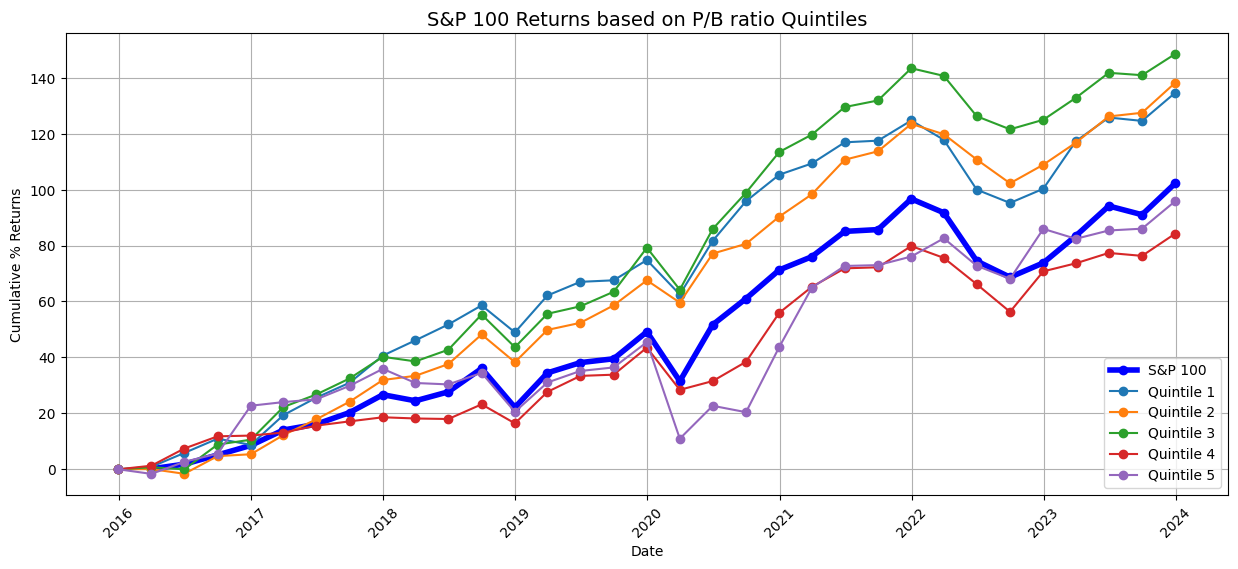

In [4]:
# separate each of the S&P returns into their quintiles & plot with S&P 100 reference
prices = pd.read_csv('data/sp100_prices.csv')
prices_df = prices.copy()
prices_df.loc[:, prices_df.columns != "date"] = prices_df.loc[:, prices_df.columns != "date"].pct_change() * 100

# TODO: Should really be re-weighting the portfolios each quarter rather than just the start
# weighted mapping
weights = quintile_df["market_cap_quintile_weight"].reindex(prices_df.columns)
quintile_mapping = quintile_df["Quintile"].to_dict()

def weighted_avg(df, weights):
    return (df * weights).sum(axis=1) / weights.sum()

grouped_prices_df = prices_df.groupby(quintile_mapping, axis=1).apply(
    lambda group: weighted_avg(group, weights.loc[group.columns])
)

grouped_prices_df.columns = [f"Quintile {int(col)}" for col in grouped_prices_df.columns]
grouped_prices_df = grouped_prices_df.cumsum()

grouped_prices_df["date"] = prices_df["date"]
grouped_prices_df.set_index("date", inplace=True)
grouped_prices_df.index = pd.to_datetime(grouped_prices_df.index)

plt.figure(figsize=(15, 6))
plt.plot(oex_df.index, oex_df['Cumulative_pct_change'], marker='o', linewidth=4, color='b', label='S&P 100')
for column in grouped_prices_df.columns:
    plt.plot(grouped_prices_df.index, grouped_prices_df[column], label=column, marker='o')

plt.title("S&P 100 Returns based on P/B ratio Quintiles", fontsize=14)
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Cumulative % Returns")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

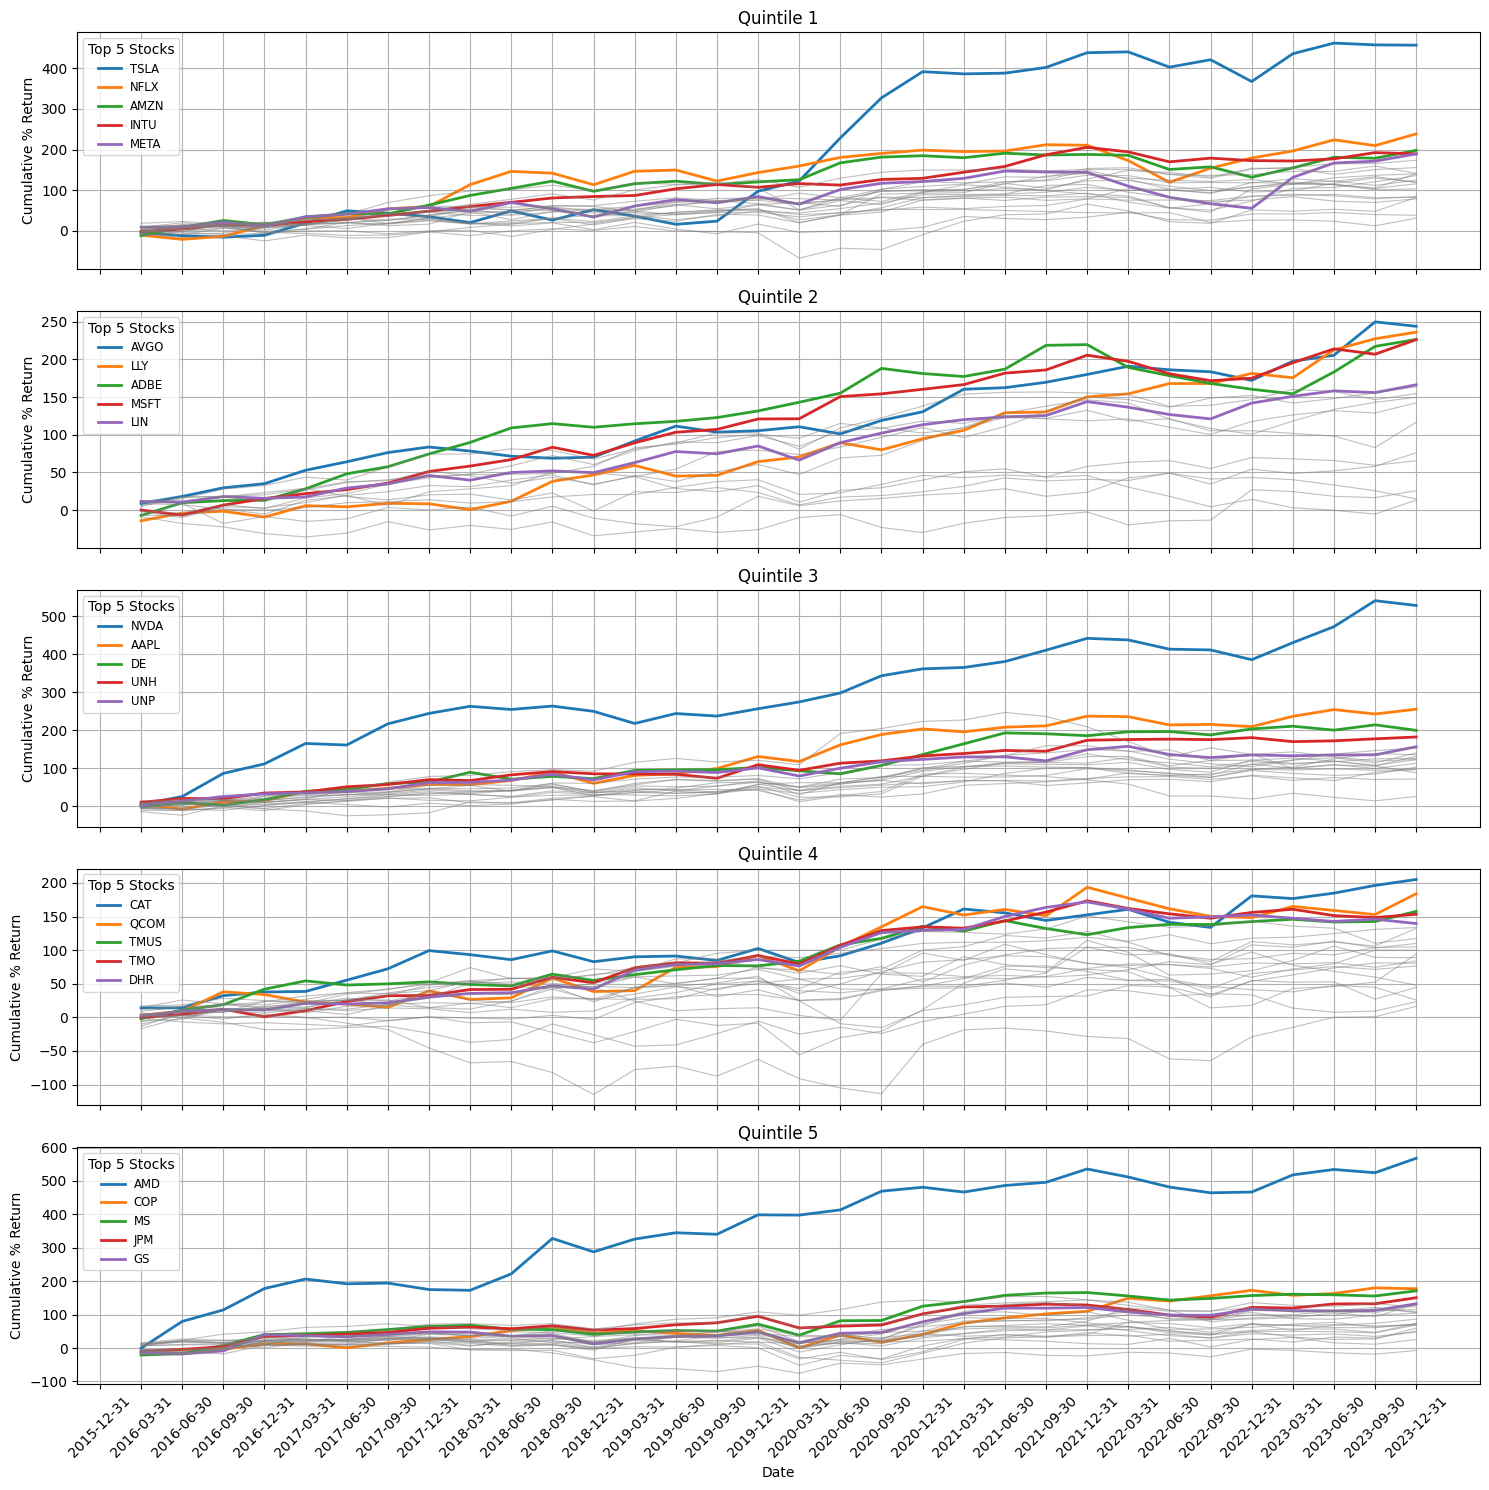

In [5]:
# plot each quintile / bucket separately
display_stocks_df = prices_df.copy()
display_stocks_df.set_index("date", inplace=True)
display_stocks_df = display_stocks_df.cumsum()
num_buckets = len(set(quintile_mapping.values()))
num_stocks_to_show = 5

fig, axes = plt.subplots(num_buckets, 1, figsize=(15, 15), sharex=True)  # 5 subplots vertically

for i in range(num_buckets):
    quintile_stocks = [stock for stock in display_stocks_df.columns if quintile_mapping[stock] == i + 1]
    sorted_stocks = sorted(quintile_stocks, key=lambda stock: display_stocks_df[stock].iloc[-1], reverse=True)

    # Plot the top stocks first. (consistent colours)
    for stock in sorted_stocks[:num_stocks_to_show]:
        axes[i].plot(display_stocks_df.index, display_stocks_df[stock], label=stock, linewidth=2)

    for stock in sorted_stocks[num_stocks_to_show:]:
        axes[i].plot(display_stocks_df.index, display_stocks_df[stock], color="gray", alpha=0.5, linewidth=0.8)

    axes[i].legend(loc="upper left", fontsize="small", title=f"Top {num_stocks_to_show} Stocks")
    axes[i].set_title(f'Quintile {i + 1}')
    axes[i].set_ylabel("Cumulative % Return")
    axes[i].grid(True)

plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## t-Statistics, Information Ratios and Information Coefficients

Separate portfolio return into two components, one benchmark related - the other non benchmark related.

$$\boxed{ r(t) = \alpha + \beta \cdot r_{B}(t) + \epsilon(t) }$$

The regression will estimate the portfolio's alpha and beta and evaluate via the _t statistic_ whether the alpha is significantly different from zero.

The _t statistic_ for the portfolios alpha is:

$$\boxed{ t{-}stat = \frac{\alpha}{SE(\alpha)} }$$

as simply the ratio od the estimated alpha to the standard error of the estimate.  (Assuming normal distribution if t statistic > 2 then probability the alpha is generated by chance is < 5%


The _t statistic_ and the information ratio are closely related.  The information ratio is the ratio of annual alpha to its annual risk.  If we observe returns over a period of _T_ years the IR is approx the _t statistic divided by the square root of the number of years of observarion.

$$ \boxed{ IR \approx \frac{ t{-}stat}{\sqrt{T}} } $$

The information coefficient.  This correlation between forcast and realized alphas is a critical component in determining the information ratio (as per the fundamental law of active management.

- All noise and no signal, the information coefficient is 0
- All signal and no noise the information coefficient is 1
- The IC can be negatice so must lie between -1 and 1

$$ \boxed{ IR \approx IC \cdot \sqrt{(BR)} } $$

In [6]:
# do a regression for our quintile data and the benchmark
aligned_data = grouped_prices_df.copy()
aligned_data["Benchmark"] = oex_df["OEX_pct_change"]
aligned_data.at[aligned_data.index[0], 'Benchmark'] = 0

regression_results = {}

# Iterate through each quintile and perform regression
for column in aligned_data.columns:
    if column.startswith("Quintile"):
        x = aligned_data["Benchmark"]  # Benchmark returns (independent variable)
        y = aligned_data[column]  # Portfolio returns (dependent variable)
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()

        print(model.summary())

        regression_results[column] = {
            "Alpha": model.params["const"],
            "Beta": model.params["Benchmark"],
            "Alpha t-statistic": model.tvalues["const"],
            "Beta t-statistic": model.tvalues["Benchmark"],
            "R-squared": model.rsquared,
            "p-value (Alpha)": model.pvalues["const"],
            "p-value (Beta)": model.pvalues["Benchmark"]
        }

for quintile, results in regression_results.items():
    print(f"Regression for {quintile}:")
    for key, value in results.items():
        print(f"    {key}: {value:.4f}")
    print("\n")

                            OLS Regression Results                            
Dep. Variable:             Quintile 1   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.8469
Date:                Mon, 20 Jan 2025   Prob (F-statistic):              0.365
Time:                        20:18:24   Log-Likelihood:                -169.61
No. Observations:                  33   AIC:                             343.2
Df Residuals:                      31   BIC:                             346.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.5965      7.932      8.648      0.0

## Event Studies
Some data does not arrive in neat cross-sectional packages.  Some information-laden events occur at different times for different assets.  Where cross-sectional information analysis looks at all the information arriving at a date, event studies look at information with a type of event.

Some examples (limited only by imagination and existence of data
- An earnings announcement
- A new CEO
- A change in dividend
- A stock split

Three types of variables at play in an event study

- Description (often this is 0/1 variable - it happened or didn't - or could be e.g. 'earning surprise')
- Asset returns after the event.  (due to timing mismatches in events, typically use asset residual returns after the event)
- Conditioning variables from before the event (e.g. characterising the event)

**How to do an Event Study**
- start with &nbsp; $n =1,2,...,N$ &nbsp; events
- residual returns cumulated from period 1 to period _j_ following each event &nbsp; $\theta_{n}(1,j)$
- The residual risk estimate over the period &nbsp; $\omega_{n}(1,j)$
- The conditional variables &nsbp; $X_{nk}$ &nbsp; where &nbsp; $k = 1,2, ..., K$ &nbsp; indexes the different conditioning variables for each event &nbsp; $n$

$$\boxed{ \frac{\omega_{n}(1,j)}{\theta_{n}(1,j)} = b_{0}(1,j) + \sum_{k}X_{nk} \cdot b_{k}(1,j) + \epsilon_{n}(1,j) }$$

Given above (regresion analysis) and an event that just occurred the forecast alpha over the next _j_ periods is


$$\boxed{ \alpha_{n}(1,j) = \omega_{n}(1,j) \cdot \left[ b_{0}(1,j) + \sum_{k}X_{nk} \cdot b_{k}(1,j) \right]  }$$

- above is consistent with volatility ⋅ IC ⋅ score rule of thumb
- $\omega_{n}(1,j)$ &nbsp; is the volatility
- The fitted part of the regression &nbsp; $b_{0}(1,j) + \sum_{k}X_{nk} \cdot b_{k}(1,j)$ &nbsp; will be of the order of IC ⋅ score since we have made the dependent variable standardised

**Relationship to Cross-sectional Studies**

- One simple model is to assume number of trading days between events follows geometric distribution
- The probability that an event will occur on any given day is _p_
- The probability that the next event occurs in _j_ days is &nbsp; $ p \cdot (1-p)^{j-1} $
- Assuming the information coefficent decays exponentially over time we have for _j_ days after the event

$$\boxed{ IC(j) = IC(1) \cdot \gamma^{j-1} }$$

- Assuming _J_ trading days per year and _N_ roughly similar assets this model estimates

$$\boxed{ IC(J) = IC(1) \cdot \frac{(1-\gamma^{J})}{(1-\gamma) \cdot \sqrt{J}} }$$

and

$$\boxed{ IR = IC(J) \cdot \sqrt{\frac{p \cdot N}{1- (1-p) \cdot \gamma^{2}}} }$$

In [45]:
# TODO: Figure 12.3
def half_live_days_to_gamma(days):
    return np.exp( np.log(0.5)/days )

def ic_j(ic_1, J, half_life):
    return ic_1 * (1-half_life**J)/((1-half_life)*np.sqrt(J))

ic = 0.04
N = 1000
J = 252
half_lives = half_live_days_to_gamma([1, 7, 30, 30*3, 30*6, 30*12])

events_per_year = np.array(range(1,13))
event_probs = events_per_year/J

## Pitfalls of Information Analysis

- Done correctly we are _separating the wheat from the chaff_
- Done incorrectly we are _data mining_

Data mining can fool an analyst into believing  information exists when it does not.  Surprisingly easy to search through historical data and find patterns that don't really exist.  (The statistics of co-incidence)

Four guidelines can help keep information analysis turning into data mining

- **Intuition:** &emsp; guide the search for information before the backtest begins
- **Restraint:** &emsp; statistical analysis shows that given enough trials of valueless information one incarnation will look good
- **Sensibleness:** &emsp; performance should be sensible, always septically exampine eg IR above 2
- **Out of Sample Testing:** &emsp; verify on a second set of historical data (check for overfit)